# SpaceX Falcon 9 First Stage Landing Prediction
# 
#  Laboratorio 1: Obtención de Datos
# 
# En este laboratorio, obtendremos datos de la API de SpaceX y crearemos un DataFrame con la información de los lanzamientos.

In [10]:
# Celda 1: Importación de librerías y configuración inicial
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [11]:
# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")

print("Librerías importadas y configuración establecida correctamente.")

Librerías importadas y configuración establecida correctamente.


In [12]:
# Celda 2: Definición de funciones auxiliares para obtener datos de la API
# URL de la API de SpaceX
SPACEX_API_URL = "https://api.spacexdata.com/v4/launches/past"

# Listas para almacenar los datos
BoosterVersion = []
LaunchSite = []
Longitude = []
Latitude = []
PayloadMass = []
Orbit = []
Block = []
ReusedCount = []
Serial = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []

def getBoosterVersion(data):
    """Obtiene la versión del cohete desde la API"""
    for x in data['rocket']:
        if x:
            response = requests.get(f"https://api.spacexdata.com/v4/rockets/{str(x)}").json()
            BoosterVersion.append(response['name'])

def getLaunchSite(data):
    """Obtiene información del sitio de lanzamiento desde la API"""
    for x in data['launchpad']:
        if x:
            response = requests.get(f"https://api.spacexdata.com/v4/launchpads/{str(x)}").json()
            Longitude.append(response['longitude'])
            Latitude.append(response['latitude'])
            LaunchSite.append(response['name'])

def getPayloadData(data):
    """Obtiene información de la carga útil desde la API"""
    for load in data['payloads']:
        if load:
            response = requests.get(f"https://api.spacexdata.com/v4/payloads/{load}").json()
            PayloadMass.append(response['mass_kg'])
            Orbit.append(response['orbit'])

def getCoreData(data):
    """Obtiene información del núcleo del cohete desde la API"""
    for core in data['cores']:
        if core['core'] is not None:
            response = requests.get(f"https://api.spacexdata.com/v4/cores/{core['core']}").json()
            Block.append(response['block'])
            ReusedCount.append(response['reuse_count'])
            Serial.append(response['serial'])
        else:
            Block.append(None)
            ReusedCount.append(None)
            Serial.append(None)
        Outcome.append(str(core['landing_success']) + ' ' + str(core['landing_type']))
        Flights.append(core['flight'])
        GridFins.append(core['gridfins'])
        Reused.append(core['reused'])
        Legs.append(core['legs'])
        LandingPad.append(core['landpad'])

print("Funciones auxiliares definidas correctamente.")

Funciones auxiliares definidas correctamente.


In [13]:
# Celda 3: Obtención de datos de la API de SpaceX
print("Obteniendo datos de lanzamientos de SpaceX...")
response = requests.get(SPACEX_API_URL)

if response.status_code != 200:
    print(f"Error al obtener datos: {response.status_code}")
else:
    data = response.json()
    print(f"Datos obtenidos correctamente. Total de lanzamientos: {len(data)}")

    # Limpiar listas antes de procesar
    lists_to_clear = [BoosterVersion, LaunchSite, Longitude, Latitude, 
                     PayloadMass, Orbit, Block, ReusedCount, Serial, 
                     Outcome, Flights, GridFins, Reused, Legs, LandingPad]

    for lst in lists_to_clear:
        lst.clear()

    # Funciones corregidas
    def getBoosterVersion(data):
        """Obtiene la versión del cohete desde la API"""
        for launch in data:
            rocket_id = launch.get('rocket')
            if rocket_id:
                rocket_info = requests.get(f"https://api.spacexdata.com/v4/rockets/{rocket_id}").json()
                BoosterVersion.append(rocket_info.get('name'))
            else:
                BoosterVersion.append(None)

    def getLaunchSite(data):
        """Obtiene el sitio de lanzamiento"""
        for launch in data:
            launchpad_id = launch.get('launchpad')
            if launchpad_id:
                site_info = requests.get(f"https://api.spacexdata.com/v4/launchpads/{launchpad_id}").json()
                LaunchSite.append(site_info.get('name'))
                Longitude.append(site_info.get('longitude'))
                Latitude.append(site_info.get('latitude'))
            else:
                LaunchSite.append(None)
                Longitude.append(None)
                Latitude.append(None)

    def getPayloadData(data):
        """Obtiene datos de la carga útil"""
        for launch in data:
            payloads = launch.get('payloads', [])
            if payloads:
                # Tomamos el primer payload (podrías recorrerlos todos si quieres más detalle)
                payload_info = requests.get(f"https://api.spacexdata.com/v4/payloads/{payloads[0]}").json()
                PayloadMass.append(payload_info.get('mass_kg'))
                Orbit.append(payload_info.get('orbit'))
            else:
                PayloadMass.append(None)
                Orbit.append(None)

    def getCoreData(data):
        """Obtiene información del core (propulsores)"""
        for launch in data:
            cores = launch.get('cores', [])
            if cores and isinstance(cores, list):
                core = cores[0]  # Tomamos el primer core
                Block.append(core.get('block'))
                ReusedCount.append(core.get('reused'))
                Serial.append(core.get('core'))
                Outcome.append("Success" if core.get('landing_success') else "Failure")
                Flights.append(core.get('flight'))
                GridFins.append(core.get('gridfins'))
                Reused.append(core.get('reused'))
                Legs.append(core.get('legs'))
                LandingPad.append(core.get('landpad'))
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
                Outcome.append(None)
                Flights.append(None)
                GridFins.append(None)
                Reused.append(None)
                Legs.append(None)
                LandingPad.append(None)

    # Procesar datos con funciones corregidas
    getBoosterVersion(data)
    getLaunchSite(data)
    getPayloadData(data)
    getCoreData(data)

    # Crear DataFrame
    launch_dict = {
        'FlightNumber': list(range(1, len(data) + 1)),
        'Date': [x['date_utc'] for x in data],
        'BoosterVersion': BoosterVersion,
        'LaunchSite': LaunchSite,
        'Longitude': Longitude,
        'Latitude': Latitude,
        'PayloadMass': PayloadMass,
        'Orbit': Orbit,
        'Block': Block,
        'ReusedCount': ReusedCount,
        'Serial': Serial,
        'Outcome': Outcome,
        'Flights': Flights,
        'GridFins': GridFins,
        'Reused': Reused,
        'Legs': Legs,
        'LandingPad': LandingPad,
        'Success': [x['success'] for x in data]
    }

    df = pd.DataFrame(launch_dict)
    print("DataFrame creado exitosamente.")


Obteniendo datos de lanzamientos de SpaceX...
Datos obtenidos correctamente. Total de lanzamientos: 187
DataFrame creado exitosamente.


In [14]:
# Celda 4: Mostrar información del dataset
print(f"\nDataset creado con {df.shape[0]} filas y {df.shape[1]} columnas")

print("\nPrimeras 5 filas del dataset:")
display(df.head())

print("\nInformación del dataset:")
df_info = df.info()  # guardar la salida en una variable (para no imprimir 'None')
print(df_info)



Dataset creado con 187 filas y 18 columnas

Primeras 5 filas del dataset:


,FlightNumber,Date,BoosterVersion,LaunchSite,Longitude,Latitude,PayloadMass,Orbit,Block,ReusedCount,Serial,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Success
0,1,2006-03-24T22:30:00.000Z,Falcon 1,Kwajalein Atoll,167.743129,9.047721,20.0,LEO,None,False,5e9e289df35918033d3b2623,Failure,1,False,False,False,None,False
1,2,2007-03-21T01:10:00.000Z,Falcon 1,Kwajalein Atoll,167.743129,9.047721,NaN,LEO,None,False,5e9e289ef35918416a3b2624,Failure,1,False,False,False,None,False
2,3,2008-08-03T03:34:00.000Z,Falcon 1,Kwajalein Atoll,167.743129,9.047721,NaN,LEO,None,False,5e9e289ef3591814873b2625,Failure,1,False,False,False,None,False
3,4,2008-09-28T23:15:00.000Z,Falcon 1,Kwajalein Atoll,167.743129,9.047721,165.0,LEO,None,False,5e9e289ef3591855dc3b2626,Failure,1,False,False,False,None,True
4,5,2009-07-13T03:35:00.000Z,Falcon 1,Kwajalein Atoll,167.743129,9.047721,200.0,LEO,None,False,5e9e289ef359184f103b2627,Failure,1,False,False,False,None,True



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    187 non-null    int64  
 1   Date            187 non-null    object 
 2   BoosterVersion  187 non-null    object 
 3   LaunchSite      187 non-null    object 
 4   Longitude       187 non-null    float64
 5   Latitude        187 non-null    float64
 6   PayloadMass     162 non-null    float64
 7   Orbit           186 non-null    object 
 8   Block           0 non-null      object 
 9   ReusedCount     187 non-null    bool   
 10  Serial          187 non-null    object 
 11  Outcome         187 non-null    object 
 12  Flights         187 non-null    int64  
 13  GridFins        187 non-null    bool   
 14  Reused          187 non-null    bool   
 15  Legs            187 non-null    bool   
 16  LandingPad      151 non-null    object 
 17  Success  

#  Laboratorio 2: Limpieza y Transformación de Datos
# 
# En este laboratorio, limpiaremos y transformaremos los datos para el análisis.

In [16]:
# Celda 5: Limpieza y transformación de datos
print("Limpiando y transformando datos...")

# Crear una copia del DataFrame
df_clean = df.copy()

# Manejar valores nulos en PayloadMass (forma recomendada, sin warning)
media_payload = df_clean['PayloadMass'].mean()
df_clean['PayloadMass'] = df_clean['PayloadMass'].fillna(media_payload)

# Extraer el año de la fecha
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Year'] = df_clean['Date'].dt.year

# Crear variable objetivo para clasificación
# 1 = aterrizaje exitoso, 0 = aterrizaje fallido
df_clean['LandingSuccess'] = df_clean['Outcome'].apply(
    lambda x: 1 if x == "Success" else 0
)

# Asegurar que Reused (True/False) sea numérico
df_clean['Reused'] = df_clean['Reused'].astype(int)

# Codificación de variables categóricas
label_encoder = preprocessing.LabelEncoder()
df_clean['BoosterVersion_encoded'] = label_encoder.fit_transform(df_clean['BoosterVersion'])
df_clean['LaunchSite_encoded'] = label_encoder.fit_transform(df_clean['LaunchSite'])
df_clean['Orbit_encoded'] = label_encoder.fit_transform(df_clean['Orbit'])

print("Limpieza y transformación de datos completada.")


Limpiando y transformando datos...
Limpieza y transformación de datos completada.


In [17]:
# Celda 6: Mostrar información del dataset limpio
print(f"\nDataset después de la limpieza: {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas")
print("\nTipos de datos y valores nulos:")
print(df_clean.info())

print("\nPrimeras 5 filas del dataset limpio:")
display(df_clean.head())


Dataset después de la limpieza: 187 filas y 23 columnas

Tipos de datos y valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   FlightNumber            187 non-null    int64              
 1   Date                    187 non-null    datetime64[ns, UTC]
 2   BoosterVersion          187 non-null    object             
 3   LaunchSite              187 non-null    object             
 4   Longitude               187 non-null    float64            
 5   Latitude                187 non-null    float64            
 6   PayloadMass             187 non-null    float64            
 7   Orbit                   186 non-null    object             
 8   Block                   0 non-null      object             
 9   ReusedCount             187 non-null    bool               
 10  Serial              

,FlightNumber,Date,BoosterVersion,LaunchSite,Longitude,Latitude,PayloadMass,Orbit,Block,ReusedCount,Serial,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Success,Year,LandingSuccess,BoosterVersion_encoded,LaunchSite_encoded,Orbit_encoded
0,1,2006-03-24 22:30:00+00:00,Falcon 1,Kwajalein Atoll,167.743129,9.047721,20.000000,LEO,None,False,5e9e289df35918033d3b2623,Failure,1,False,0,False,None,False,2006,0,0,2,6
1,2,2007-03-21 01:10:00+00:00,Falcon 1,Kwajalein Atoll,167.743129,9.047721,7868.373765,LEO,None,False,5e9e289ef35918416a3b2624,Failure,1,False,0,False,None,False,2007,0,0,2,6
2,3,2008-08-03 03:34:00+00:00,Falcon 1,Kwajalein Atoll,167.743129,9.047721,7868.373765,LEO,None,False,5e9e289ef3591814873b2625,Failure,1,False,0,False,None,False,2008,0,0,2,6
3,4,2008-09-28 23:15:00+00:00,Falcon 1,Kwajalein Atoll,167.743129,9.047721,165.000000,LEO,None,False,5e9e289ef3591855dc3b2626,Failure,1,False,0,False,None,True,2008,0,0,2,6
4,5,2009-07-13 03:35:00+00:00,Falcon 1,Kwajalein Atoll,167.743129,9.047721,200.000000,LEO,None,False,5e9e289ef359184f103b2627,Failure,1,False,0,False,None,True,2009,0,0,2,6


#  Laboratorio 3: Análisis Exploratorio y Modelado
# 
# En este laboratorio, realizaremos un análisis exploratorio y entrenaremos un modelo de predicción.

In [18]:
# Celda 7: Análisis exploratorio de datos
print("Realizando análisis exploratorio de datos...")

# Estadísticas descriptivas
print("\n1. ESTADÍSTICAS DESCRIPTIVAS:")
display(df_clean.describe())

# Distribución de aterrizajes exitosos vs fallidos
print("\n2. DISTRIBUCIÓN DE ATERRIZAJES EXITOSOS:")
print(df_clean['LandingSuccess'].value_counts())

Realizando análisis exploratorio de datos...

1. ESTADÍSTICAS DESCRIPTIVAS:


,FlightNumber,Longitude,Latitude,PayloadMass,Flights,Reused,Year,LandingSuccess,BoosterVersion_encoded,LaunchSite_encoded,Orbit_encoded
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,94.000000,-79.939916,28.962590,7868.373765,3.636364,0.614973,2018.844920,0.764706,0.989305,0.796791,7.368984
std,54.126395,43.571372,3.952563,5213.190632,3.267034,0.487908,3.279541,0.425321,0.207113,1.058194,3.874052
min,1.000000,-120.610829,9.047721,20.000000,1.000000,0.000000,2006.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,-80.603956,28.561857,3118.000000,1.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,5.000000
50%,94.000000,-80.577366,28.561857,7868.373765,2.000000,1.000000,2020.000000,1.000000,1.000000,0.000000,7.000000
75%,140.500000,-80.577366,28.608058,13260.000000,5.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,12.000000
max,187.000000,167.743129,34.632093,15600.000000,14.000000,1.000000,2022.000000,1.000000,2.000000,3.000000,13.000000



2. DISTRIBUCIÓN DE ATERRIZAJES EXITOSOS:
LandingSuccess
1    143
0     44
Name: count, dtype: int64


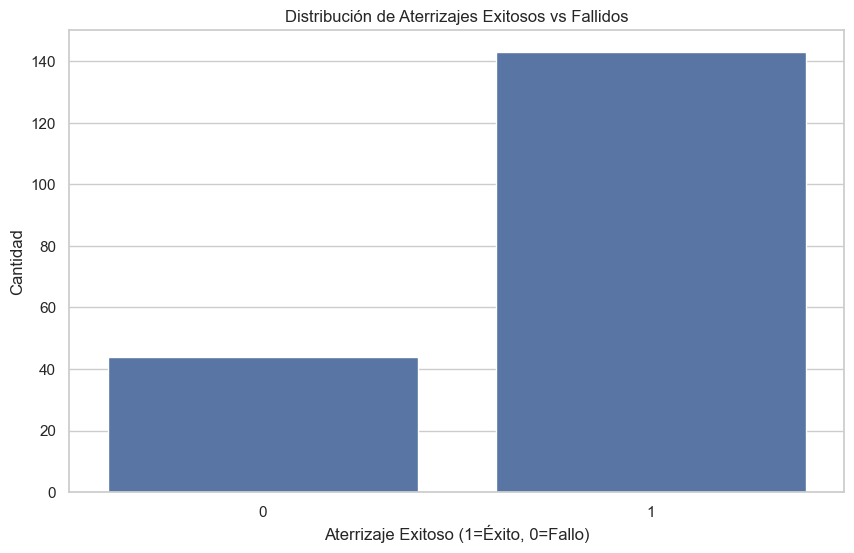

In [19]:
# Celda 8: Visualización de la distribución de aterrizajes
plt.figure(figsize=(10, 6))
sns.countplot(x='LandingSuccess', data=df_clean)
plt.title('Distribución de Aterrizajes Exitosos vs Fallidos')
plt.xlabel('Aterrizaje Exitoso (1=Éxito, 0=Fallo)')
plt.ylabel('Cantidad')
plt.show()


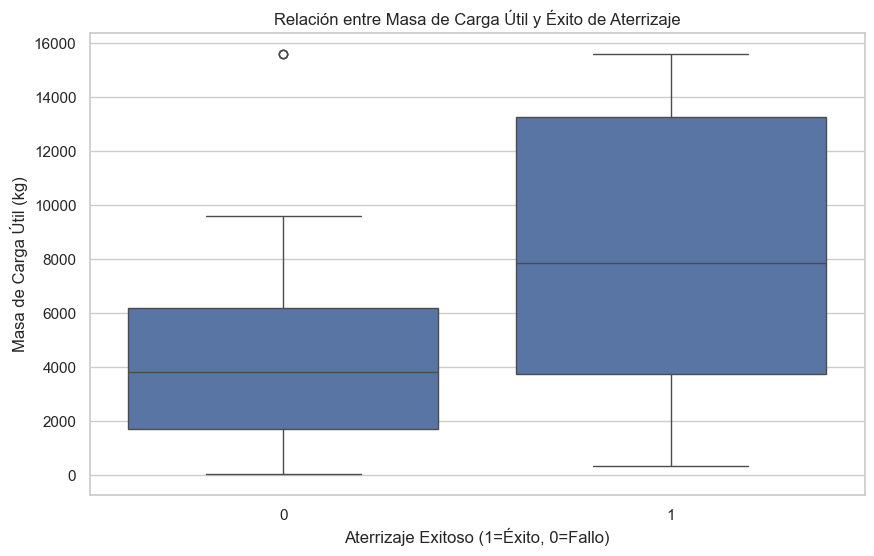

In [20]:
# Celda 9: Relación entre masa de carga útil y éxito de aterrizaje
plt.figure(figsize=(10, 6))
sns.boxplot(x='LandingSuccess', y='PayloadMass', data=df_clean)
plt.title('Relación entre Masa de Carga Útil y Éxito de Aterrizaje')
plt.xlabel('Aterrizaje Exitoso (1=Éxito, 0=Fallo)')
plt.ylabel('Masa de Carga Útil (kg)')
plt.show()


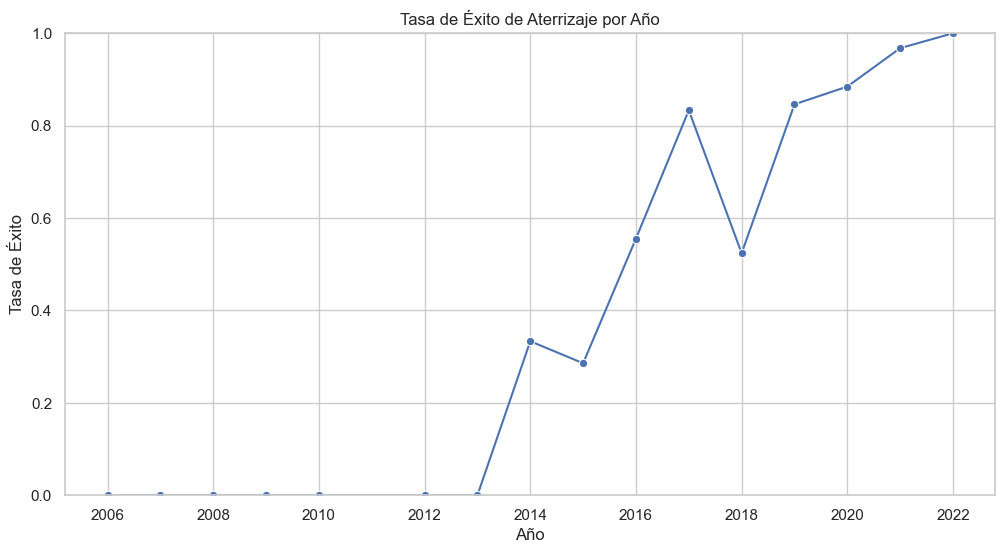

In [21]:
# Celda 10: Éxito de aterrizaje por año
plt.figure(figsize=(12, 6))
exito_por_anio = df_clean.groupby('Year')['LandingSuccess'].mean().reset_index()
sns.lineplot(x='Year', y='LandingSuccess', data=exito_por_anio, marker='o')
plt.title('Tasa de Éxito de Aterrizaje por Año')
plt.xlabel('Año')
plt.ylabel('Tasa de Éxito')
plt.ylim(0, 1)
plt.show()

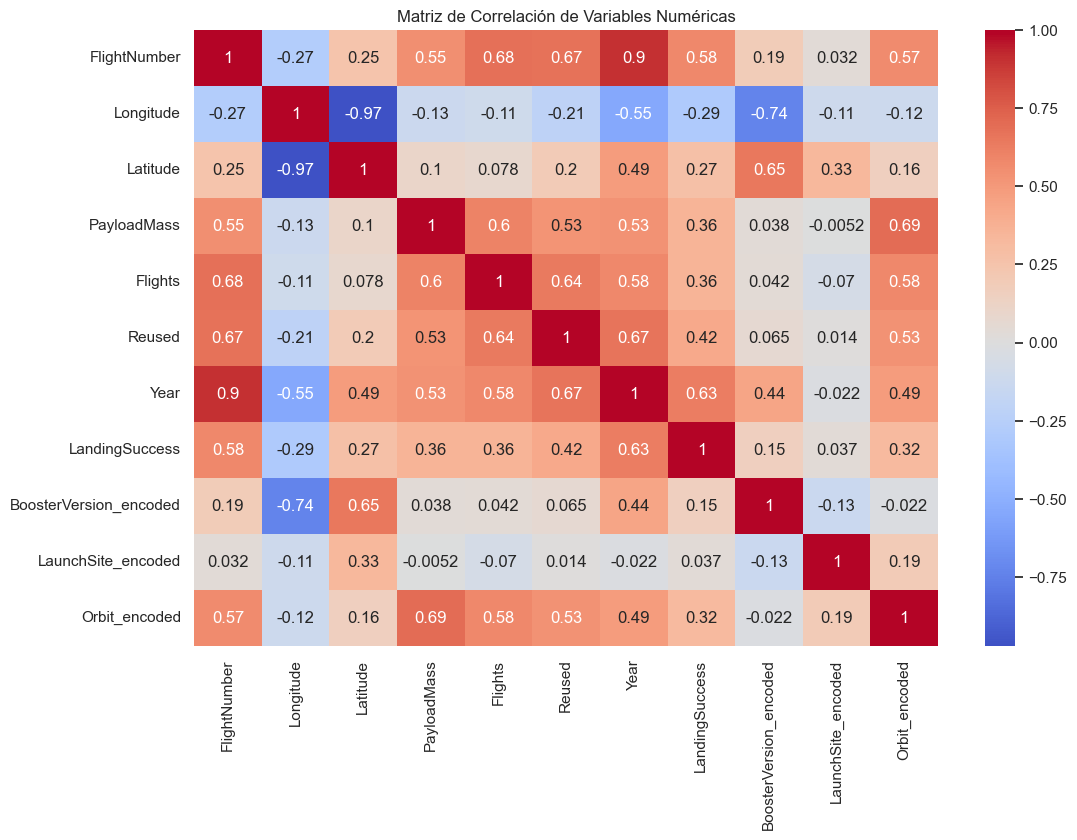

In [22]:
# Celda 11: Matriz de correlación
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [23]:
# Celda 12: Preparación de características y objetivo
# Crear características para el modelo
features = df_clean[[
    'FlightNumber', 'PayloadMass', 'Flights', 'GridFins', 
    'Reused', 'Legs', 'BoosterVersion_encoded', 
    'LaunchSite_encoded', 'Orbit_encoded', 'Year'
]]

target = df_clean['LandingSuccess']

print("\nCaracterísticas para el modelo:")
display(features.head())

print("\nVariable objetivo:")
print(target.head())


Características para el modelo:


,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,BoosterVersion_encoded,LaunchSite_encoded,Orbit_encoded,Year
0,1,20.000000,1,False,0,False,0,2,6,2006
1,2,7868.373765,1,False,0,False,0,2,6,2007
2,3,7868.373765,1,False,0,False,0,2,6,2008
3,4,165.000000,1,False,0,False,0,2,6,2008
4,5,200.000000,1,False,0,False,0,2,6,2009



Variable objetivo:
0    0
1    0
2    0
3    0
4    0
Name: LandingSuccess, dtype: int64


In [25]:
# Celda 13: Entrenamiento del modelo con escalado
print("Entrenando modelo de predicción...")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

# Escalar los datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelo de regresión logística
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo: {accuracy:.2f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Entrenando modelo de predicción...

Precisión del modelo: 0.82

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.82      0.97      0.89        29

    accuracy                           0.82        38
   macro avg       0.79      0.65      0.68        38
weighted avg       0.81      0.82      0.79        38



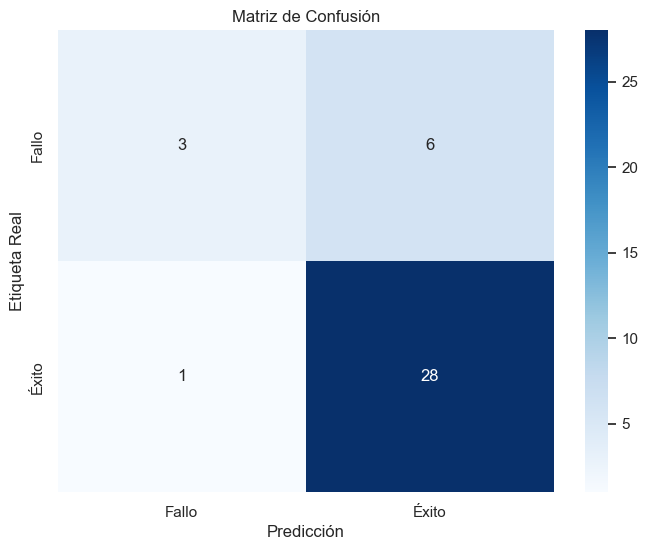

In [26]:
# Celda 14: Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fallo', 'Éxito'],
            yticklabels=['Fallo', 'Éxito'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

In [27]:
# Celda 15: Resumen final
print("\n" + "=" * 60)
print("RESUMEN EJECUCIÓN COMPLETADA")
print("=" * 60)
print("Fase 1 del proyecto completada exitosamente.")
print("Se han ejecutado los tres laboratorios integrados:")
print("1. Obtención de datos desde la API de SpaceX")
print("2. Limpieza y transformación de datos")
print("3. Análisis exploratorio y modelo de predicción")
print(f"   - Precisión del modelo: {accuracy:.2f}")


RESUMEN EJECUCIÓN COMPLETADA
Fase 1 del proyecto completada exitosamente.
Se han ejecutado los tres laboratorios integrados:
1. Obtención de datos desde la API de SpaceX
2. Limpieza y transformación de datos
3. Análisis exploratorio y modelo de predicción
   - Precisión del modelo: 0.82
